In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [2]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("zhengxuanzenwu/wikitext-2-split-128")

print(dataset)

## Self Attention

https://www.youtube.com/watch?v=QUk6jvB9RGk&list=PLE3Y6O9R81ly4UmavfbfaRKbih605E_uG&index=24

In [2]:
import numpy as np

# Define a list of 20 simple sentences
sentences = [
    "the cat sat on the mat",
    "the dog sat on the mat",
    "the cat slept on the bed",
    "the dog slept on the bed",
    "the cat played with the ball",
    "the dog played with the ball",
    "the cat ate food from the bowl",
    "the dog ate food from the bowl",
    "the cat drank water from the bowl",
    "the dog drank water from the bowl",
    "the cat chased the mouse",
    "the dog chased the mouse",
    "the cat climbed the tree",
    "the dog climbed the tree",
    "the cat is very cute",
    "the dog is very cute",
    "the cat is very smart",
    "the dog is very smart",
    "the cat has a collar",
    "the dog has a collar",
]

# Define a list of unique words
vocab = ["the", "cat", "dog", "sat", "on", "mat", "slept", "bed", "played", "with", "food", "bowl", "drank", 
         "water", "chased", "mouse", "climbed", "tree", "is", "very", "cute", "smart", "has", "a", "collar"]

# Create a dictionary to map words to indices
word2idx = {word: idx for idx, word in enumerate(vocab)}

# Create a function to tokenize a sentence
def tokenize(sentence):
    tokens = sentence.split()
    token_ids = [word2idx.get(token, len(word2idx)) for token in tokens]
    return token_ids

# Tokenize the sentences
tokenized_sentences = [tokenize(sentence) for sentence in sentences]

# Convert the tokenized sentences to a numpy array for training your model
#data = np.array(tokenized_sentences)

In [3]:
import torch
import math
from torch import nn, matmul
from torch.nn.functional import softmax

w_query = torch.tensor([
    [0, 0, 1],
    [1, 1, 0],
    [0, 1, 0],
    [1, 1, 0]
], dtype=torch.float32)

w_key = torch.tensor([
    [1, 0, 1],
    [1, 0, 0],
    [0, 1, 0],
    [1, 0, 1]
], dtype=torch.float32)

w_value = torch.tensor([
    [1, 0, 1],
    [1, 1, 0],
    [0, 1, 1],
    [0, 0, 1]
], dtype=torch.float32)

x = torch.tensor([[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
],
[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
]], dtype=torch.float32)

class SelfAttention(nn.Module):
    def __init__(self, embedding_dimension, model_dimension):
        super(SelfAttention, self).__init__()
        self.embedding_dimension = embedding_dimension
        self.model_dimension = model_dimension
        self.to_query = nn.Linear(embedding_dimension, model_dimension, bias=False)
        self.to_query.weight = nn.Parameter(w_query.t())
        self.to_key = nn.Linear(embedding_dimension, model_dimension, bias=False)
        self.to_key.weight = nn.Parameter(w_key.t())
        self.to_value = nn.Linear(embedding_dimension, model_dimension, bias=False)
        self.to_value.weight = nn.Parameter(w_value.t())

    def forward(self, inputs):
        # crating q, k and v using input vectors
        q = self.to_query(inputs)
        k = self.to_key(inputs)
        v = self.to_value(inputs)
        # compute attention scores
        #attention_scores = matmul(q, k.t())
        batched_attention_scores = matmul(q, k.transpose(-1, -2))
        # convert attentions scores with softmax to probability distributions
        batched_softmax_attention = softmax(batched_attention_scores, dim=-1)
        print('Batched_softmax_attention')
        print(batched_softmax_attention)
        #print('v')
        #print(v)
        #v_formatted = v[:, None]
        #print('v_formatted')
        #print(v_formatted)
        #softmax_attention_transposed = softmax_attention.t()
        #softmax_attention_transposed_formatted = softmax_attention_transposed[:, :, None]
        #print('softmax_attention_transposed_formatted')
        #print(softmax_attention_transposed_formatted)
        #v_weighted = softmax_attention_transposed_formatted * v_formatted
        #print('v_weighted')
        #print(v_weighted)
        #output = v_weighted.sum(dim=0)
        #print('output')
        #print(output)
        print('matmul')
        output = matmul(batched_softmax_attention, v)
        print(output)

    def forwardnew(self, inputs):
            # crating q, k and v using input vectors
            q = self.to_query(inputs)
            k = self.to_key(inputs)
            v = self.to_key(inputs)
            # compute attention scores
            attention_scores = matmul(q, k.transpose(-1, -2))
            # convert attentions scores with softmax to probability distributions
            softmax_attention = softmax(attention_scores, dim=-1)        
            print('matmul')
            print(matmul(softmax_attention, v))

attention_model = SelfAttention(4, 3)
attention_model(x)

Batched_softmax_attention
tensor([[[9.0031e-02, 6.6524e-01, 2.4473e-01],
         [1.5229e-08, 9.9995e-01, 4.5398e-05],
         [4.5094e-05, 9.9326e-01, 6.6925e-03]],

        [[9.0031e-02, 6.6524e-01, 2.4473e-01],
         [1.5229e-08, 9.9995e-01, 4.5398e-05],
         [4.5094e-05, 9.9326e-01, 6.6925e-03]]], grad_fn=<SoftmaxBackward0>)
matmul
tensor([[[1.9100, 3.2405, 3.5752],
         [2.0000, 3.9999, 4.0000],
         [2.0000, 3.9865, 3.9932]],

        [[1.9100, 3.2405, 3.5752],
         [2.0000, 3.9999, 4.0000],
         [2.0000, 3.9865, 3.9932]]], grad_fn=<UnsafeViewBackward0>)


In [23]:
import torch
import math
from torch import nn, matmul
from torch.nn.functional import softmax

w_query = torch.tensor([
    [0, 0, 1],
    [1, 1, 0],
    [0, 1, 0],
    [1, 1, 0]
], dtype=torch.float32)

w_key = torch.tensor([
    [1, 0, 1],
    [1, 0, 0],
    [0, 1, 0],
    [1, 0, 1]
], dtype=torch.float32)

w_value = torch.tensor([
    [1, 0, 1],
    [1, 1, 0],
    [0, 1, 1],
    [0, 0, 1]
], dtype=torch.float32)

w_unify_heads = torch.tensor([
    [1, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 0],
], dtype=torch.float32)

x = torch.tensor([[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
],
[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
]], dtype=torch.float32)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dimension, head_dimension, heads=2):
        super(MultiHeadSelfAttention, self).__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = head_dimension
        # Head 1
        self.to_query_head1 = nn.Linear(embedding_dimension, head_dimension, bias=False)
        self.to_query_head1.weight = nn.Parameter(w_query.t())
        self.to_key_head1 = nn.Linear(embedding_dimension, head_dimension, bias=False)
        self.to_key_head1.weight = nn.Parameter(w_key.t())
        self.to_value_head1 = nn.Linear(embedding_dimension, head_dimension, bias=False)
        self.to_value_head1.weight = nn.Parameter(w_value.t())

        # Head 2
        self.to_query_head2 = nn.Linear(embedding_dimension, head_dimension, bias=False)
        self.to_query_head2.weight = nn.Parameter(w_query.t())
        self.to_key_head2 = nn.Linear(embedding_dimension, head_dimension, bias=False)
        self.to_key_head2.weight = nn.Parameter(w_key.t())
        self.to_value_head2 = nn.Linear(embedding_dimension, head_dimension, bias=False)
        self.to_value_head2.weight = nn.Parameter(w_value.t())

        self.unify_heads = nn.Linear(heads * head_dimension, head_dimension)
        self.unify_heads.weight = nn.Parameter(w_unify_heads.t())

    def forward(self, inputs):
        # head 1
        # crating q, k and v using input vectors
        q_head1 = self.to_query_head1(inputs)
        k_head1 = self.to_key_head1(inputs)
        v_head1 = self.to_value_head1(inputs)

        batched_attention_scores_head1 = matmul(q_head1, k_head1.transpose(-1, -2))
        # convert attentions scores with softmax to probability distributions
        batched_softmax_attention_head1 = softmax(batched_attention_scores_head1, dim=-1)
        print('Batched_softmax_attention head1')
        print(batched_softmax_attention_head1)
        print('matmul')
        output_head1 = matmul(batched_softmax_attention_head1, v_head1)
        print(output_head1)

        # head 2
        # crating q, k and v using input vectors
        q_head2 = self.to_query_head2(inputs)
        k_head2 = self.to_key_head2(inputs)
        v_head2 = self.to_value_head2(inputs)

        batched_attention_scores_head2 = matmul(q_head2, k_head2.transpose(-1, -2))
        # convert attentions scores with softmax to probability distributions
        batched_softmax_attention_head2 = softmax(batched_attention_scores_head2, dim=-1)
        print('Batched_softmax_attention head2')
        print(batched_softmax_attention_head2)
        print('matmul')
        output_head2 = matmul(batched_softmax_attention_head2, v_head2)
        print(output_head2)
        output_head1_head2 = torch.cat([output_head1, output_head2], dim=-1)
        print(output_head1_head2)
        output_final = self.unify_heads(output_head1_head2)
        print(output_final)

multihead_attention_model = MultiHeadSelfAttention(4, 3)
multihead_attention_model(x)

Batched_softmax_attention head1
tensor([[[9.0031e-02, 6.6524e-01, 2.4473e-01],
         [1.5229e-08, 9.9995e-01, 4.5398e-05],
         [4.5094e-05, 9.9326e-01, 6.6925e-03]],

        [[9.0031e-02, 6.6524e-01, 2.4473e-01],
         [1.5229e-08, 9.9995e-01, 4.5398e-05],
         [4.5094e-05, 9.9326e-01, 6.6925e-03]]], grad_fn=<SoftmaxBackward0>)
matmul
tensor([[[1.9100, 3.2405, 3.5752],
         [2.0000, 3.9999, 4.0000],
         [2.0000, 3.9865, 3.9932]],

        [[1.9100, 3.2405, 3.5752],
         [2.0000, 3.9999, 4.0000],
         [2.0000, 3.9865, 3.9932]]], grad_fn=<UnsafeViewBackward0>)
Batched_softmax_attention head2
tensor([[[9.0031e-02, 6.6524e-01, 2.4473e-01],
         [1.5229e-08, 9.9995e-01, 4.5398e-05],
         [4.5094e-05, 9.9326e-01, 6.6925e-03]],

        [[9.0031e-02, 6.6524e-01, 2.4473e-01],
         [1.5229e-08, 9.9995e-01, 4.5398e-05],
         [4.5094e-05, 9.9326e-01, 6.6925e-03]]], grad_fn=<SoftmaxBackward0>)
matmul
tensor([[[1.9100, 3.2405, 3.5752],
         [2.00

In [ ]:
import torch
import math
from torch import nn, matmul
from torch.nn.functional import softmax

w_query = torch.tensor([
    [0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 1, 0, 1, 1, 0]
], dtype=torch.float32)

w_key = torch.tensor([
    [1, 0, 1, 1, 0, 1],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 1]
], dtype=torch.float32)

w_value = torch.tensor([
    [1, 0, 1, 1, 0, 1],
    [1, 1, 0, 1, 1, 0],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 1, 0, 0, 1]
], dtype=torch.float32)

w_unify_heads = torch.tensor([
    [1, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 0],
], dtype=torch.float32)

x = torch.tensor([[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
],
[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
]], dtype=torch.float32)

class NMultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dimension, head_dimension, heads=2):
        super(NMultiHeadSelfAttention, self).__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = head_dimension
        self.heads = heads
        # Head 1
        self.to_query = nn.Linear(embedding_dimension, heads * head_dimension, bias=False)
        self.to_query.weight = nn.Parameter(w_query.t())
        self.to_key = nn.Linear(embedding_dimension, heads * head_dimension, bias=False)
        self.to_key.weight = nn.Parameter(w_key.t())
        self.to_value = nn.Linear(embedding_dimension, heads * head_dimension, bias=False)
        self.to_value.weight = nn.Parameter(w_value.t())

        self.unify_heads = nn.Linear(heads * head_dimension, head_dimension)
        self.unify_heads.weight = nn.Parameter(w_unify_heads.t())

    def forward(self, inputs):
        # heads
        # crating q, k and v using input vectors
        q = self.to_query(inputs)
        k = self.to_key(inputs)
        v = self.to_value(inputs)

        batched_attention_scores = matmul(q, k.transpose(-1, -2))
        # convert attentions scores with softmax to probability distributions
        batched_softmax_attention = softmax(batched_attention_scores, dim=-1)
        print('Batched_softmax_attention')
        print(batched_softmax_attention)
        print('matmul')
        output = matmul(batched_softmax_attention, v)
        print(output)

        # head 2
        # crating q, k and v using input vectors
        q_head2 = self.to_query_head2(inputs)
        k_head2 = self.to_key_head2(inputs)
        v_head2 = self.to_value_head2(inputs)

        batched_attention_scores_head2 = matmul(q_head2, k_head2.transpose(-1, -2))
        # convert attentions scores with softmax to probability distributions
        batched_softmax_attention_head2 = softmax(batched_attention_scores_head2, dim=-1)
        print('Batched_softmax_attention head2')
        print(batched_softmax_attention_head2)
        print('matmul')
        output_head2 = matmul(batched_softmax_attention_head2, v_head2)
        print(output_head2)
        output_head1_head2 = torch.cat([output_head1, output_head2], dim=-1)
        print(output_head1_head2)
        output_final = self.unify_heads(output_head1_head2)
        print(output_final)

nmultihead_attention_model = NMultiHeadSelfAttention(4, 2, 3)
nmultihead_attention_model(x)

## Load Huggingface dataset (sst2 dataset)

### https://huggingface.co/datasets/stanfordnlp/sst2

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [2]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

model_id = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [3]:
dataset = load_dataset("glue", "sst2")
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [4]:
counter = 0
for item in dataset['test']:
    print(item)
    if counter > 10:
        break
    counter += 1

{'sentence': 'uneasy mishmash of styles and genres .', 'label': -1, 'idx': 0}
{'sentence': "this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .", 'label': -1, 'idx': 1}
{'sentence': 'by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .', 'label': -1, 'idx': 2}
{'sentence': 'director rob marshall went out gunning to make a great one .', 'label': -1, 'idx': 3}
{'sentence': 'lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .', 'label': -1, 'idx': 4}
{'sentence': 'a well-made and often lovely depiction of the mysteries of friendship .', 'label': -1, 'idx': 5}
{'sentence': "none of this violates the letter of behan 's book , but missing is its spirit , its ribald , full-throated humor .", 'label': -1, 'idx': 6}
{'sentence': "although it bangs a very cliched drum at times , this cro

In [216]:
imdb_dataset = load_dataset("imdb")
imdb_dataset

counter = 0
for item in imdb_dataset['test']:
    print(item)
    if counter > 10:
        break
    counter += 1

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

In [5]:
def tokenize_fs(batch):
    return tokenizer(batch['sentence'], truncation=True)

In [6]:
tokenized_datasets = dataset.map(tokenize_fs, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [8]:
tokenized_datasets['train'][1]

{'sentence': 'contains no wit , only labored gags ',
 'label': 0,
 'idx': 1,
 'input_ids': [101,
  2515,
  1185,
  20787,
  117,
  1178,
  5530,
  1174,
  21102,
  1116,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])

In [10]:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [11]:
tokenized_datasets["train"]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 67349
})

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_datasets["train"],
                              shuffle=True,
                              batch_size=32,
                              collate_fn=data_collator)
validation_dataloader = DataLoader(tokenized_datasets["validation"],
                              batch_size=32,
                              collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_datasets["test"],
                              batch_size=32,
                              collate_fn=data_collator)

In [13]:
for batch in train_dataloader:
    for k, v in batch.items():
        #print("k:", k, "v.shape:", v.shape)
        print("k:", k, v)
    break

k: labels tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1])
k: input_ids tensor([[  101,  1103,  1273,  ...,     0,     0,     0],
        [  101,  1228, 14262,  ...,     0,     0,     0],
        [  101,   170, 25395,  ...,     0,     0,     0],
        ...,
        [  101,  1307,  1105,  ...,     0,     0,     0],
        [  101, 22345,   102,  ...,     0,     0,     0],
        [  101,  3709,  1103,  ...,     0,     0,     0]])
k: attention_mask tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [14]:
for batch in test_dataloader:
    for k, v in batch.items():
        #print("k:", k, "v.shape:", v.shape)
        print("k:", k, v)
    break

k: labels tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
k: input_ids tensor([[  101, 16782,  1940,  ...,     0,     0,     0],
        [  101,  1142,  1273,  ...,     0,     0,     0],
        [  101,  1118,  1103,  ...,     0,     0,     0],
        ...,
        [  101,  1303,   112,  ...,     0,     0,     0],
        [  101,  1211,  1207,  ...,     0,     0,     0],
        [  101,  1177,  1374,  ...,     0,     0,     0]])
k: attention_mask tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [15]:
tokenizer.vocab_size

28996

In [ ]:
tokenizer.max_model_input_sizes[model_id] # 1024

## Multihead Attention for n heads

In [16]:
import torch
import math
from torch import nn, matmul
from torch.nn.functional import softmax

w_query = torch.tensor([
    [0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 1, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 1, 0, 1, 1, 0]
], dtype=torch.float32)

w_key = torch.tensor([
    [1, 0, 1, 1, 0, 1],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 1]
], dtype=torch.float32)

w_value = torch.tensor([
    [1, 0, 1, 1, 0, 1],
    [1, 1, 0, 1, 1, 0],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 1, 0, 0, 1]
], dtype=torch.float32)

w_unify_heads = torch.tensor([
    [1, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 0],
], dtype=torch.float32)

x = torch.tensor([[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
],
[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
],
[
    [1, 0, 1, 0], # input 1
    [0, 2, 2, 2], # input 2
    [1, 1, 1, 1], # input 3
]], dtype=torch.float32)

(100, 1)


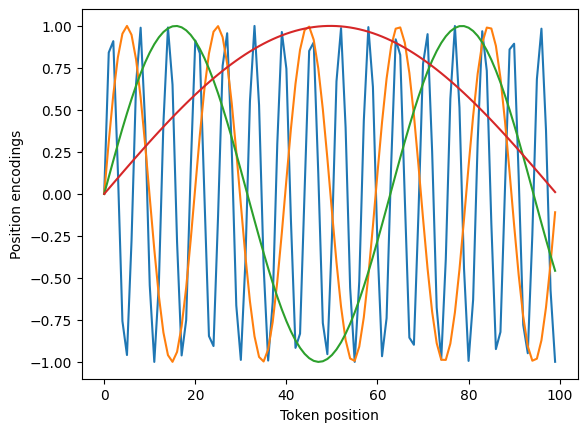

In [18]:
import matplotlib.pyplot as plt
import numpy as np

model_dimension = 32
max_positions = 100

i_0 = 0
position_encodings_i0 = [[position / np.power(10000, 2*i_0/model_dimension)] for position in range(0, max_positions)]
sin_i0 = np.sin(position_encodings_i0)

i_2 = 2
position_encodings_i2 = [[position / np.power(10000, 2*i_2/model_dimension)] for position in range(0, max_positions)]
sin_i2 = np.sin(position_encodings_i2)

i_4 = 4
position_encodings_i4 = [[position / np.power(10000, 2*i_4/model_dimension)] for position in range(0, max_positions)]
sin_i4 = np.sin(position_encodings_i4)

i_6 = 6
position_encodings_i6 = [[position / np.power(10000, 2*i_6/model_dimension)] for position in range(0, max_positions)]
sin_i6 = np.sin(position_encodings_i6)

#print(sin_i2)
print(sin_i2.shape)
#cos_i2 = np.cos(i2)
x = range(0, max_positions)
y = sin_i2
plt.plot(x, sin_i0, label=f'{i_0}')
plt.plot(x, sin_i2, label=f'{i_2}')
plt.plot(x, sin_i4, label=f'{i_4}')
plt.plot(x, sin_i6, label=f'{i_6}')
plt.xlabel("Token position")
plt.ylabel("Position encodings")
plt.show()


In [33]:
class TPositionalEncoding(nn.Module):
    def __init__(self, model_dimension, max_length, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        pe = torch.zeros(max_length, model_dimension)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dimension, 2).float() * -(math.log(10000.0) / model_dimension))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
    
        #position_encodings = np.array([
        #    [position / np.power(10000, 2 * i / model_dimension) for i in range(model_dimension)]
        #    if (position != 0) else torch.zeros(model_dimension) for position in range (0, max_length)
        #])

        #position_encodings[1: 0::2] = torch.sin(position_encodings[1:, 0::2])
        #position_encodings[1: 1::2] = torch.cos(position_encodings[1:, 1::2])
        #print(position_encodings.shape)
        
        #tensor_position_encodings = torch.tensor(position_encodings)
        # print(tensor_position_encodings.shape)            
        
        #tensor_position_encodings[1:, 0::2] = torch.sin(tensor_position_encodings[1:, 0::2])
        #tensor_position_encodings[1:, 1::2] = torch.cos(tensor_position_encodings[1:, 1::2])
        
        #print(tensor_position_encodings.shape)
        #print(tensor_position_encodings[2])
        #self.position_encodings = tensor_position_encodings
        #self.register_buffer('pe', tensor_position_encodings)

    def forward(self, x, mask=None):
        print(x.shape)
        print(self.pe.shape)
        position_encodings_transformed = self.pe[:, :x.size(1)]
        print(position_encodings_transformed.shape)
        x = x + position_encodings_transformed
        return x

positionalencoding = TPositionalEncoding(64, 512)

In [ ]:
input_ids = None
masked_attention = None
for batch in train_dataloader:
    for k, v in batch.items():
        #print("k:", k, "v.shape:", v.shape)        
        if k == "input_ids":
            input_ids = v #.to(device)
        if k == "attention_mask ":
            masked_attention = v #.to(device)
    break
#print(input_ids.shape)
positionalencoding = TPositionalEncoding(64, 512)
x = positionalencoding(input_ids, masked_attention)
print(x.shape)
print(x)

In [189]:
from torch import nn, matmul
from torch.nn.functional import softmax
import torch.nn.utils.rnn as rnn_utils

class PrePositionalEncoding(nn.Module):
    def __init__(self, model_dimension, max_length):
        super(PrePositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_length, model_dimension)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dimension, 2).float() * -(math.log(10000.0) / model_dimension))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))        
        
    def forward(self, x):
        #print(f"x.shape: {x.shape}")
        #print(f"x.size(1): {x.size(1)}")
        #print(f"self.pe.shape: {self.pe.shape}")
        position_encodings_transformed = self.pe[:, :x.size(1), :]
        #print(f"position_encodings_transformed: {position_encodings_transformed.shape}")
        x = x + position_encodings_transformed
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, model_dimension, max_length, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)
        position_encodings = np.array([
            [position / np.power(10000, 2 * i / model_dimension) for i in range(model_dimension)]
            if (position != 0) else torch.zeros(model_dimension) for position in range (0, max_length)
        ])
        print(position_encodings.shape)
        tensor_position_encodings = torch.tensor(position_encodings, dtype=torch.float)
        tensor_position_encodings[1:, 0::2] = torch.sin(tensor_position_encodings[1:, 0::2])
        tensor_position_encodings[1:, 1::2] = torch.cos(tensor_position_encodings[1:, 1::2])
        #print(tensor_position_encodings.shape)
        #self.register_buffer('pe', tensor_position_encodings)
        self.position_encoding = tensor_position_encodings.unsqueeze(0)
        print(self.position_encoding.shape)
        #print(self.position_encoding)

    def forward(self, x):        
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        #print(x.shape)
        #print(self.position_encoding.shape)        
        #x = x + self.position_encoding[:x.size(0)]
        #positional_encoding_expanded = self.position_encoding.expand(x.size(0), x.size(1), x.size(2))
        #print(positional_encoding_expanded.shape)
        #x = x + positional_encoding_expanded        
        x = x + self.position_encoding[:, :x.size(1), :]        
        #x = x + self.pe[:x.size(0)]
        #print(self.position_encoding.shape)
        #print(self.position_encoding)
        #position_encoding_expanded = self.position_encoding.unsqueeze(0).expand(x.size(0), x.size(1), x.size(2))
        #print(position_encoding_expanded.shape)
        #torch.Size([32, 40, 64])
        #torch.Size([16, 64])
        #x = x + self.pe[:, :x.size(1)]
        return x

class PreMultiHeadAttention(nn.Module):
    def __init__(self, model_dimension, heads=2):
        super(PreMultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert model_dimension % heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.model_dimension = model_dimension # Model's dimension
        self.heads = heads # Number of attention heads
        self.d_k = model_dimension // heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(model_dimension, model_dimension) # Query transformation
        self.W_k = nn.Linear(model_dimension, model_dimension) # Key transformation
        self.W_v = nn.Linear(model_dimension, model_dimension) # Value transformation
        self.W_o = nn.Linear(model_dimension, model_dimension) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.model_dimension)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        # print(output.shape)
        return output

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, model_dimension, heads=2):
        super(MultiHeadSelfAttention, self).__init__()
        # self.embedding_dimension = embedding_dimension
        self.model_dimension = model_dimension
        self.heads = heads        
        # Heads
        self.to_query = nn.Linear(model_dimension, heads * model_dimension, bias=True)
        #self.to_query.weight = nn.Parameter(w_query.t())
        self.to_key = nn.Linear(model_dimension, heads * model_dimension, bias=True)
        #self.to_key.weight = nn.Parameter(w_key.t())
        self.to_value = nn.Linear(model_dimension, heads * model_dimension, bias=True)
        #self.to_value.weight = nn.Parameter(w_value.t())
        self.unify_heads = nn.Linear(heads * model_dimension, model_dimension, bias=True)
        #self.unify_heads.weight = nn.Parameter(w_unify_heads.t())

    def forward(self, inputs):
        # heads
        # crating q, k and v using input vectors                
        bs, seq, dim = inputs.shape        
        q = self.to_query(inputs).view(bs, seq, self.heads, self.model_dimension).transpose(1, 2)
        k = self.to_key(inputs).view(bs, seq, self.heads, self.model_dimension).transpose(1, 2)        
        v = self.to_value(inputs).view(bs, seq, self.heads, self.model_dimension).transpose(1, 2)        
        # scale dot-product befor matmul
        #q = q / self.head_dimension ** (1/float(4))
        #k = k / self.head_dimension ** (1/float(4))
        batched_attention_scores = matmul(q, k.transpose(-1, -2))
        # scale dot-product after matmul
        batched_attention_scores = batched_attention_scores / self.model_dimension ** (1/float(2))
        # convert attentions scores with softmax to probability distributions
        batched_softmax_attention = softmax(batched_attention_scores, dim=-1)
        #print('Batched_softmax_attention')
        #print(batched_softmax_attention)
        #print('matmul')
        output = matmul(batched_softmax_attention, v)        
        output = output.transpose(1, 2).contiguous().view(bs, seq, self.heads * self.model_dimension)
        #print('output')
        #print(output)
        # Unify heads        
        output_final = self.unify_heads(output)
        #print('output_final shape')
        #print(output_final.shape)
        return output_final

class FeedForward(nn.Module):
    def __init__(self, model_dimension, feedforward_dimension, dropout=0.1):
        super().__init__()
        self.fully_connected_1 = nn.Linear(model_dimension, feedforward_dimension)
        self.fully_connected_2 = nn.Linear(feedforward_dimension, model_dimension)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #self.fully_connected_2(self.relu(self.dropout(self.fully_connected_1(x))))
        x = self.fully_connected_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fully_connected_2(x)
        return x

class SimpleEncoder(nn.Module):    
    def __init__(self, vocab_size, model_dimension, max_length, feedforward_dimension, heads, n_classes):
        super().__init__()          
        self.padding_idx = 0      
        self.embedding = nn.Embedding(vocab_size, model_dimension, padding_idx = self.padding_idx)   
        print(f"model_dimension: {model_dimension}, max_length: {max_length}")
        self.positional_encoding = PositionalEncoding(model_dimension, max_length)
        # self.multiheadselfattention = MultiHeadSelfAttention(model_dimension, heads)
        self.multiheadselfattention = PreMultiHeadAttention(model_dimension, heads)
        # nmultihead_attention_model = MultiHeadSelfAttention(4, 3, 8)
        self.attentionNorm = nn.LayerNorm(model_dimension)
        self.feedforward = FeedForward(model_dimension, feedforward_dimension)
        self.finalNorm = nn.LayerNorm(model_dimension)
        self.finalDropout = nn.Dropout(0.1)
        self.fully_connected = nn.Linear(model_dimension, n_classes)        

    def forward(self, x, mask=None):  
        x = rnn_utils.pad_sequence(x, batch_first=True, padding_value=self.padding_idx)
        # Forward pass through the embedding layer        
        #print(f"after padding: {x.shape}")
        x = self.embedding(x)
        #print(f"after embedding: {x.shape}")
        x = self.positional_encoding(x)
        #print(f"after positional encoding: {x.shape}")
        #x = self.attentionNorm(x)
        #x = self.multiheadselfattention(x) 
        x = self.multiheadselfattention(x, x, x) 
        #print(f"after multiheadselfattention: {x.shape}")
        #x = x.mean(dim=1)
        #print(f"after x.mean(dim=1): {x.shape}")
        #x = x + self.finalNorm(x)        
        #x = self.finalNorm(x)        
        #x = self.feedforward(x)
        #x = x + self.finalDropout(x)
        #x = self.finalDropout(x)
        x = self.fully_connected(x)    
        #print(f"after fully_connected: {x.shape}")
        return x        

In [174]:
positionalencoding = PositionalEncoding(64, 512)

(512, 64)
torch.Size([1, 512, 64])


In [190]:
vocab_size = tokenizer.vocab_size
simpleEncoder = SimpleEncoder(vocab_size, 64, 512, 64, 2, 2)
#simpleEncoder(x)
#simpleEncoder = simpleEncoder.to(device)

model_dimension: 64, max_length: 512
(512, 64)
torch.Size([1, 512, 64])


In [191]:
input_ids = None
masked_attention = None
counter = 0
for batch in train_dataloader:
    for k, v in batch.items():
        #print("k:", k, "v.shape:", v.shape)        
        if k == "input_ids":
            input_ids = v #.to(device)
        if k == "attention_mask ":
            masked_attention = v #.to(device)        
    x = simpleEncoder(input_ids, masked_attention)
    print(x.shape)
    counter += 1
    if counter > 0:
        break
#print(input_ids.shape)


torch.Size([32, 37, 64])
torch.Size([32, 37, 2])


In [171]:
def get_accuracy(prediction, label):
    counter = 0
    correct_predictions = 0
    for item in prediction:
        item_argmax = 0
        # print(f"item0: {item[0]}, item1: {item[1]}, label: {label[counter]}")
        if item[0] > item[1]:
            item_argmax = 0
        else:
            item_argmax = 1
        if label[counter] == item_argmax:
            correct_predictions += 1 
            #print(f"Correct -> item0: {item[0]}, item1: {item[1]}, label: {label[counter]}")
        #else:
            #print(f"Not Correct -> item0: {item[0]}, item1: {item[1]}, label: {label[counter]}")
        counter += 1
    return correct_predictions / counter

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(simpleEncoder.parameters(), lr=0.01)

epochs = 10
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
print("stared training at device: ", device)

for epoch in range(epochs):
    simpleEncoder.train()
    train_loss = 0
    train_accuracy = 0
    n_train = 0
    for batch in train_dataloader:
        batch = {k: v for k, v in batch.items()} #.to(device)
        optimizer.zero_grad()                
        outputs = simpleEncoder(batch['input_ids'], batch['attention_mask']) 
        #print(outputs.shape)
        #outputs = outputs.mean(dim=1)
        #print(outputs.shape)  
        # max_pooled_output, _ = torch.max(outputs, dim=1)
        # one_hot_labels = F.one_hot(batch['labels'], num_classes=2)    
        #test, predicted = torch.max(outputs, dim=1)
        #print(f"outputs: {predicted} - {test}, label: {batch['labels']}")
        #print(f"outputs: {test.shape}, label: {batch['labels'].shape}")      
        #label = batch['labels'].to(torch.float32)
        #predicted = predicted.to(torch.float32)
        outputs = torch.mean(outputs, dim=1)
        #print(f"outputs.shape {outputs.shape}")
        loss = criterion(outputs, batch['labels'])
        accuracy = get_accuracy(outputs, batch['labels'])
        # print(accuracy)
        # print(loss.item())
        train_loss += loss.item()
        train_accuracy += accuracy
        n_train += 1        
        loss.backward()      
        optimizer.step()
    print(f"Epoch: {epoch}/{epochs}, Train Loss: {train_loss / n_train}, Train Accuracy: {train_accuracy / n_train}")
    simpleEncoder.eval()
    test_loss = 0
    test_accuracy = 0
    n_test = 0
    n_test_accuracy = 0
    for batch in validation_dataloader:
        batch = {k: v for k, v in batch.items()}   #.to(device)             
        outputs = simpleEncoder(batch['input_ids'], batch['attention_mask'])
        outputs = torch.mean(outputs, dim=1)
        loss = criterion(outputs, batch['labels'])
        accuracy = get_accuracy(outputs, batch['labels'])
        test_accuracy += accuracy
        n_test_accuracy += 1
        test_loss += loss.item()
        n_test += 1    
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    print(f"Epoch: {epoch}/{epochs}, Test Loss: {test_loss / n_test}, Test Accuracy: {test_accuracy / n_test_accuracy}")
print("ended training at device: ", device)

stared training at device:  cuda
torch.Size([32, 54, 64])
torch.Size([32, 27, 64])
torch.Size([32, 47, 64])
torch.Size([32, 45, 64])
torch.Size([32, 44, 64])
torch.Size([32, 52, 64])
torch.Size([32, 44, 64])
torch.Size([32, 38, 64])
torch.Size([32, 70, 64])
torch.Size([32, 38, 64])
torch.Size([32, 51, 64])
torch.Size([32, 47, 64])
torch.Size([32, 50, 64])
torch.Size([32, 24, 64])
torch.Size([32, 31, 64])
torch.Size([32, 36, 64])
torch.Size([32, 47, 64])
torch.Size([32, 37, 64])
torch.Size([32, 49, 64])
torch.Size([32, 42, 64])
torch.Size([32, 34, 64])
torch.Size([32, 38, 64])
torch.Size([32, 61, 64])
torch.Size([32, 35, 64])
torch.Size([32, 35, 64])
torch.Size([32, 46, 64])
torch.Size([32, 39, 64])
torch.Size([32, 43, 64])
torch.Size([32, 51, 64])
torch.Size([32, 70, 64])
torch.Size([32, 41, 64])
torch.Size([32, 41, 64])
torch.Size([32, 37, 64])
torch.Size([32, 41, 64])
torch.Size([32, 47, 64])
torch.Size([32, 42, 64])
torch.Size([32, 40, 64])
torch.Size([32, 43, 64])
torch.Size([32, 4

In [ ]:
#simpleEncoder.test()
test_loss = 0
test_accuracy = 0
n_test = 0
n_test_accuracy = 0
for batch in test_dataloader:
    batch = {k: v for k, v in batch.items()}  #.to(device)
    outputs = simpleEncoder(batch['input_ids'], batch['attention_mask'])    
    accuracy = get_accuracy(outputs, batch['labels'])
    test_accuracy += accuracy
    n_test_accuracy += 1    
print(f" Test Accuracy: {test_accuracy / n_test_accuracy}")

In [88]:
data = [    
{'sentence': "it 's a charming and often affecting journey . ", 'label': 1, 'idx': 0},
{'sentence': 'unflinchingly bleak and desperate ', 'label': 0, 'idx': 1},
{'sentence': 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ', 'label': 1, 'idx': 2},
{'sentence': "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ", 'label': 1, 'idx': 3},
{'sentence': "it 's slow -- very , very slow . ", 'label': 0, 'idx': 4},
{'sentence': 'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ', 'label': 1, 'idx': 5},
{'sentence': 'a sometimes tedious film . ', 'label': 0, 'idx': 6},
{'sentence': "or doing last year 's taxes with your ex-wife . ", 'label': 0, 'idx': 7},
{'sentence': "you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . ", 'label': 1, 'idx': 8},
{'sentence': 'the mesmerizing performances of the leads keep the film grounded and keep the audience riveted . ', 'label': 1, 'idx': 10},
{'sentence': 'uneasy mishmash of styles and genres .', 'label': -1, 'idx': 0},
{'sentence': "this film 's relationship a poor -- if durable -- imitation .", 'label': 0, 'idx': 1},
{'sentence': 'by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .', 'label': 0, 'idx': 2},
{'sentence': 'director rob marshall went out gunning to make a great one .', 'label': 1, 'idx': 3},
{'sentence': 'lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .', 'label': 1, 'idx': 4},
{'sentence': 'a well-made and often lovely depiction of the mysteries of friendship .', 'label': 1, 'idx': 5},
{'sentence': "none of this violates the letter of behan 's book , but missing is its spirit , its ribald , full-throated humor .", 'label': 1, 'idx': 6},
{'sentence': "although it bangs a very cliched drum at times , this crowd-pleaser 's fresh dialogue , energetic music , and good-natured spunk are often infectious .", 'label': 1, 'idx': 7},
{'sentence': 'it is not a mass-market entertainment but an uncompromising attempt by one artist to think about another .', 'label': 1, 'idx': 8},
{'sentence': 'this is junk food cinema at its greasiest .', 'label': 1, 'idx': 9},
{'sentence': "it 's also heavy-handed and devotes too much time to bigoted views .", 'label': 1, 'idx': 10},
{'sentence': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood i dont like it. And then bring him back as another actor. Dallas all over again.', 'label': 0},
{'sentence': "It is not worth the entertainment value of a rental, especially if you do not like action movies.A very bad movie", 'label': 0},
]
counter = 0
true_rate = 0
for item in data:
    sentence = item['sentence']
    label = item['label']    
    sentence_tokenized = tokenizer(sentence, truncation=True)    
    input_tensor = torch.tensor(sentence_tokenized['input_ids'])
    padded_tensor = torch.nn.functional.pad(input_tensor, (0, 64 - len(input_tensor)), value=0)    
    padded_tensor = padded_tensor.unsqueeze(0) #.to(device)
    outputs = simpleEncoder(padded_tensor, sentence_tokenized['attention_mask']) 
    outputs = outputs.squeeze(0)
    predicted_label = torch.argmax(outputs)
    pred = predicted_label.item()
    print(f"sentence: {sentence} - pred/label: {pred} / {label}")
    if pred == label:
        true_rate += 1
    counter += 1
print(f"true rate: {true_rate / counter}")
#sentence = tokenizer("it was really really good, very good.", truncation=True)
#sentence = tokenizer("hide new secretions from the parental units.", truncation=True) # 0
#sentence = tokenizer("remains utterly satisfied to remain the same throughout.", truncation=True) # 0
#sentence = tokenizer("goes to absurd lengths", truncation=True) # 0
#sentence = tokenizer("hide new secretions from the parental units.", truncation=True)
#sentence = tokenizer("that loves its characters and communicates something rather beautiful about human nature.", truncation=True)
#input_tensor = torch.tensor(sentence['input_ids'])
#padded_tensor = torch.nn.functional.pad(input_tensor, (0, 64 - len(input_tensor)), value=0)
#padded_tensor = padded_tensor.unsqueeze(0)
#print(padded_tensor)
#outputs = simpleEncoder(padded_tensor, sentence['attention_mask']) 
#outputs = outputs.squeeze(0)
#print(outputs)
#predicted_label = torch.argmax(outputs)
#print(predicted_label.item())

#{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}
#{'sentence': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': 1, 'idx': 2}
#{'sentence': 'remains utterly satisfied to remain the same throughout ', 'label': 0, 'idx': 3}
#{'sentence': 'goes to absurd lengths ', 'label': 0, 'idx': 10}

sentence: it 's a charming and often affecting journey .  - pred/label: 1 / 1
sentence: unflinchingly bleak and desperate  - pred/label: 1 / 0
sentence: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker .  - pred/label: 1 / 1
sentence: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales .  - pred/label: 1 / 1
sentence: it 's slow -- very , very slow .  - pred/label: 0 / 0
sentence: although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women .  - pred/label: 1 / 1
sentence: a sometimes tedious film .  - pred/label: 0 / 0
sentence: or doing last year 's taxes with your ex-wife .  - pred/label: 0 / 0
sentence: you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance .  - pred/label: 1 / 1
sentence: the mesmerizing performances of the leads keep the film grounded and keep the audien

In [166]:
import torch
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin


class MyModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, num_channels: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.param = nn.Parameter(torch.rand(num_channels, hidden_size))
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        return self.linear(x + self.param)

# create model
config = {"num_channels": 3, "hidden_size": 32, "num_classes": 10}
model = MyModel(**config)

# save locally
model.save_pretrained("netmatze-pytorch-test-model")

# push to the hub
model.push_to_hub("netmatze-pytorch-test-model")

# reload
#model = MyModel.from_pretrained("username/my-awesome-model")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 2
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    n_train = 0
    for batch in train_dataloader:
        batch = {k: v for k, v in batch.items()}
        optimizer.zero_grad()        
        print(f"input_ids: {batch['input_ids'].shape}")
        outputs = simpleEncoder(batch['input_ids'], batch['attention_mask'])        
        loss = criterion(outputs, batch['labels'])
        loss.backward()
        train_losses += loss.item() * batch['input_ids'].size(0)
        n_train += batch['input_ids'].size(0)
    train_loss = train_loss / n_train
    model.eval()
    test_loss = 0
    n_test = 0
    for batch in validation_dataloader:
        batch = {k: v for k, v in batch.items()}
        outputs = simpleEncoder(batch['input_ids'], batch['attention_mask'])
        loss = criterion(outputs, batch['labels'])
        test_loss += loss.item() * batch['input_ids'].size(0)
        n_test += batch['input_ids'].size(0)
    test_loss = test_loss / n_test
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    print(f"Epoch: {epoch}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")

In [169]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, max_lenght, model_dimension, n_classes, heads):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, model_dimension)
        self.multiheadselfattention = MultiHeadSelfAttention(model_dimension, model_dimension, heads=2)
        # nmultihead_attention_model = MultiHeadSelfAttention(4, 3, 8)
        # self.layerNorm = nn.LayerNorm(d_model)
        self.fully_connected = nn.Linear(d_model, n_classes)        

    def forward(self, x, mask=None):
        #print(x.shape)
        x = self.embedding(x)
        #print(x.shape)
        x = self.multiheadselfattention(x)
        # print(x.shape)
        #x = self.layerNorm(x)
        x = self.fully_connected(x)

In [ ]:
model = Encoder(
    vocab_size=tokenizer.vocab_size,
    max_lenght = 1024,
    d_model = 32,
    n_classes = 2,
    heads = 2
)
# model.to(device)
model

In [ ]:
input_ids = None
for batch in train_dataloader:
    for k, v in batch.items():
        #print("k:", k, "v.shape:", v.shape)
        #print("k:", k, v)
        if k == "input_ids":
            input_ids = v
    break
#print(input_ids)
model(input_ids)

## Transformer Trainings loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 2
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    n_train = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()        
        print(f"input_ids: {batch['input_ids'].shape}")
        outputs = model(batch['input_ids'], batch['attention_mask'])
        loss = criterion(outputs, batch['labels'])
        loss.backward()
        train_losses += loss.item() * batch['input_ids'].size(0)
        n_train += batch['input_ids'].size(0)
    train_loss = train_loss / n_train
    model.eval()
    test_loss = 0
    n_test = 0
    for batch in validation_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch['input_ids'], batch['attention_mask'])
        loss = criterion(outputs, batch['labels'])
        test_loss += loss.item() * batch['input_ids'].size(0)
        n_test += batch['input_ids'].size(0)
    test_loss = test_loss / n_test
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    print(f"Epoch: {epoch}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")

## Calculate Accuracy

In [ ]:
# Calculate Accuracy
model.eval()
n_correct = 0
n_total = 0
train_accuracy = 0
test_accuracy = 0
for batch in train_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(batch["input_ids"], batch["attention_mask"])
    _, predictions = torch.max(outputs, 1)
    counter = 0
    for item in predictions:
        print(f"item: {item}, lable: {batch['lables'][counter]}")        
        if (item == batch['lables'][counter]):
            n_correct += 1
        n_total += 1
        counter += 1    
train_accuracy = n_correct / n_total
n_correct = 0
n_total = 0
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(batch["input_ids"], batch["attention_mask"])
    _, predictions = torch.max(outputs, 1)
    counter = 0
    for item in predictions:
        print(f"item: {item}, lable: {batch['lables'][counter]}")        
        if (item == batch['lables'][counter]):
            n_correct += 1
        n_total += 1
        counter += 1    
test_accuracy = n_correct / n_total
print(f"Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}")